In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import string 
from string import punctuation 
import nltk 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import STOPWORDS
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import warnings 
import re
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

### 1. Reading the data 

In [2]:
df = pd.read_csv('/kaggle/input/emotions/text.csv')

In [3]:
df = df.iloc[:len(df)//5,:]

In [4]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [5]:
df.drop("Unnamed: 0",axis = 1,inplace=True)

In [6]:
df.shape

(83361, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83361 entries, 0 to 83360
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    83361 non-null  object
 1   label   83361 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [8]:
df.isnull().sum()

text     0
label    0
dtype: int64

* Assign categories to labels so that we can understand better while visualizing the data 

In [9]:
category_dict = {0:"Sadness",1:"Joy",2:"Love",3:"Anger",4:"Fear",5:"Surprise"}

In [10]:
df["Category"] = df["label"].map(category_dict)

### 2. Text Preprocessing 

* Checking duplicate values 

In [11]:
import random 

In [12]:
duplicate_list = df[df.duplicated("text")]["text"].to_list()
print(f"Total duplicates in the data: {len(duplicate_list)}")

Total duplicates in the data: 927


In [13]:
duplicate_list_s = random.sample(duplicate_list,1)
df[df["text"]==duplicate_list_s[0]]

,text,label,Category
24254,i stop about twice a month for sniffs and new ...,3,Anger
59347,i stop about twice a month for sniffs and new ...,0,Sadness


* Removing duplicates 

In [14]:
df.drop_duplicates("text",inplace=True)

In [15]:
print(f"Shape of the data after removing duplicates: {df.shape}")

Shape of the data after removing duplicates: (82434, 3)


* lowercasing,removing digits and extra white spaces 

In [16]:
df["c_text"] = df["text"].str.lower()
df["c_text"] = df["c_text"].apply(lambda x:re.sub(r"\d+","",x)) 
df["c_text"] = df["c_text"].apply(lambda x:re.sub(r"\s+"," ",x))                          

* Removing http tags and special characters

In [17]:
df["c_text"] = df["c_text"].apply(lambda x:re.sub(r"http\S+","",x))
df["c_text"] = df["c_text"].apply(lambda x:re.sub(r"[^\w\s]","",x))

* Tokenization, removing punctuation

In [18]:
df["c_text"] = df["c_text"].apply(lambda x:word_tokenize(x)) 

In [19]:
df["c_text"] = df["c_text"].apply(lambda items:[item for item in items if item not in punctuation])

* Stop words and lemmatization 

In [20]:
stop_words = stopwords.words("english")

In [21]:
com_stop_words = stop_words + list(STOP_WORDS) + list(STOPWORDS)
print(len(com_stop_words))
print(len(set(com_stop_words)))

697
418


In [22]:
df["c_text"] = df["c_text"].apply(lambda words:[word for word in words if word not in com_stop_words])

In [23]:
import nltk
import subprocess
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
    
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [24]:
lem = WordNetLemmatizer()

In [25]:
df["c_text"] = df["c_text"].apply(lambda words:" ".join([lem.lemmatize(word,pos="v") for word in words]))

In [26]:
df.head()

,text,label,Category,c_text
0,i just feel really helpless and heavy hearted,4,Fear,feel helpless heavy hearted
1,ive enjoyed being able to slouch about relax a...,0,Sadness,ive enjoy able slouch relax unwind frankly nee...
2,i gave up my internship with the dmrg and am f...,4,Fear,give internship dmrg feel distraught
3,i dont know i feel so lost,0,Sadness,dont know feel lose
4,i am a kindergarten teacher and i am thoroughl...,4,Fear,kindergarten teacher thoroughly weary job take...


### 3. Data Visualization 

* Target variable 

In [27]:
df["Category"].value_counts().to_frame().style.background_gradient("Blues")

,count
Category,
Joy,27980
Sadness,24395
Anger,11242
Fear,9211
Love,6657
Surprise,2949


In [28]:
labels = df["Category"].value_counts().index
counts = df["Category"].value_counts().values 

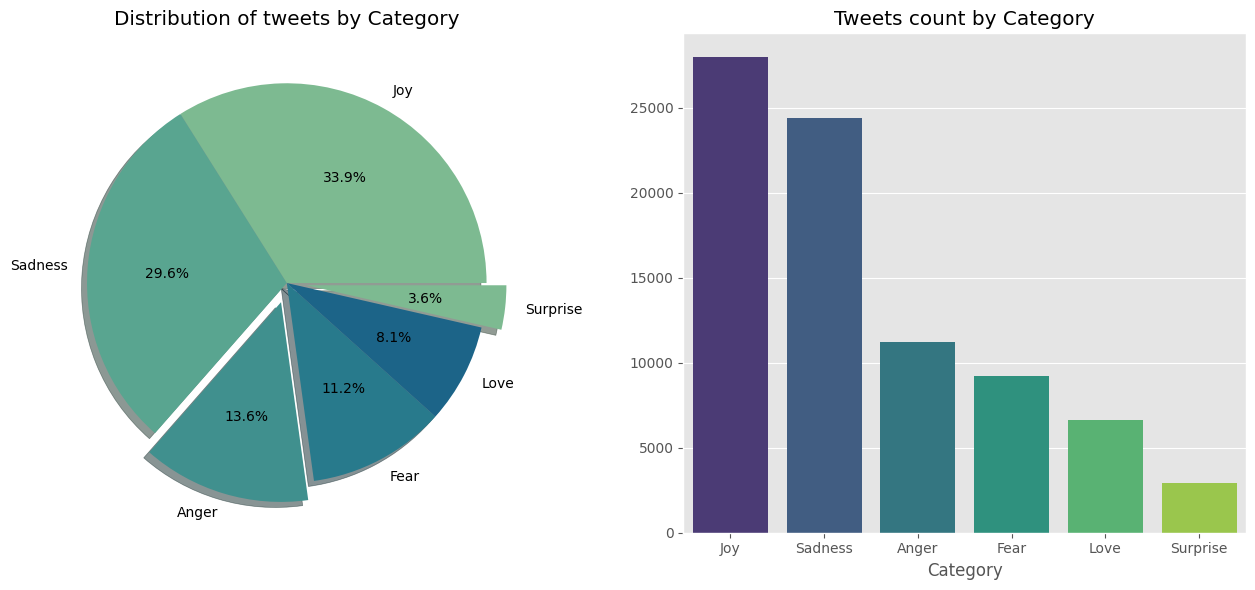

In [29]:
color = sns.color_palette("crest")[:5]
fig,axes = plt.subplots(1,2,figsize=(13,6))
axes[0].pie(counts,labels = labels,colors=color,autopct="%1.1f%%",explode = [0,0,0.1] * (len(labels)//3),
shadow = True) 
axes[0].set_title("Distribution of tweets by Category")

sns.barplot(x = labels,y = counts,palette="viridis",ax = axes[1])
axes[1].set_title("Tweets count by Category")

plt.tight_layout()
plt.show()

In [30]:
df["words_len"] = df["c_text"].str.split().str.len()

In [31]:
categories = list(df["Category"].unique())
for category in categories:
    print(category,"\n",df[df["Category"]==category]["words_len"].describe().to_frame().T)

Fear 
             count      mean       std  min  25%  50%   75%   max
words_len  9211.0  7.827597  4.326172  1.0  5.0  7.0  10.0  30.0
Sadness 
              count      mean       std  min  25%  50%   75%   max
words_len  24395.0  7.690756  4.415045  0.0  4.0  7.0  10.0  39.0
Love 
             count      mean       std  min  25%  50%   75%   max
words_len  6657.0  8.515097  4.618771  2.0  5.0  8.0  11.0  36.0
Joy 
              count      mean       std  min  25%  50%   75%   max
words_len  27980.0  8.069621  4.423158  1.0  5.0  7.0  10.0  38.0
Surprise 
             count      mean       std  min  25%  50%   75%   max
words_len  2949.0  8.215666  4.508579  2.0  5.0  7.0  11.0  30.0
Anger 
              count      mean       std  min  25%  50%   75%   max
words_len  11242.0  7.862747  4.538278  0.0  4.0  7.0  10.0  36.0


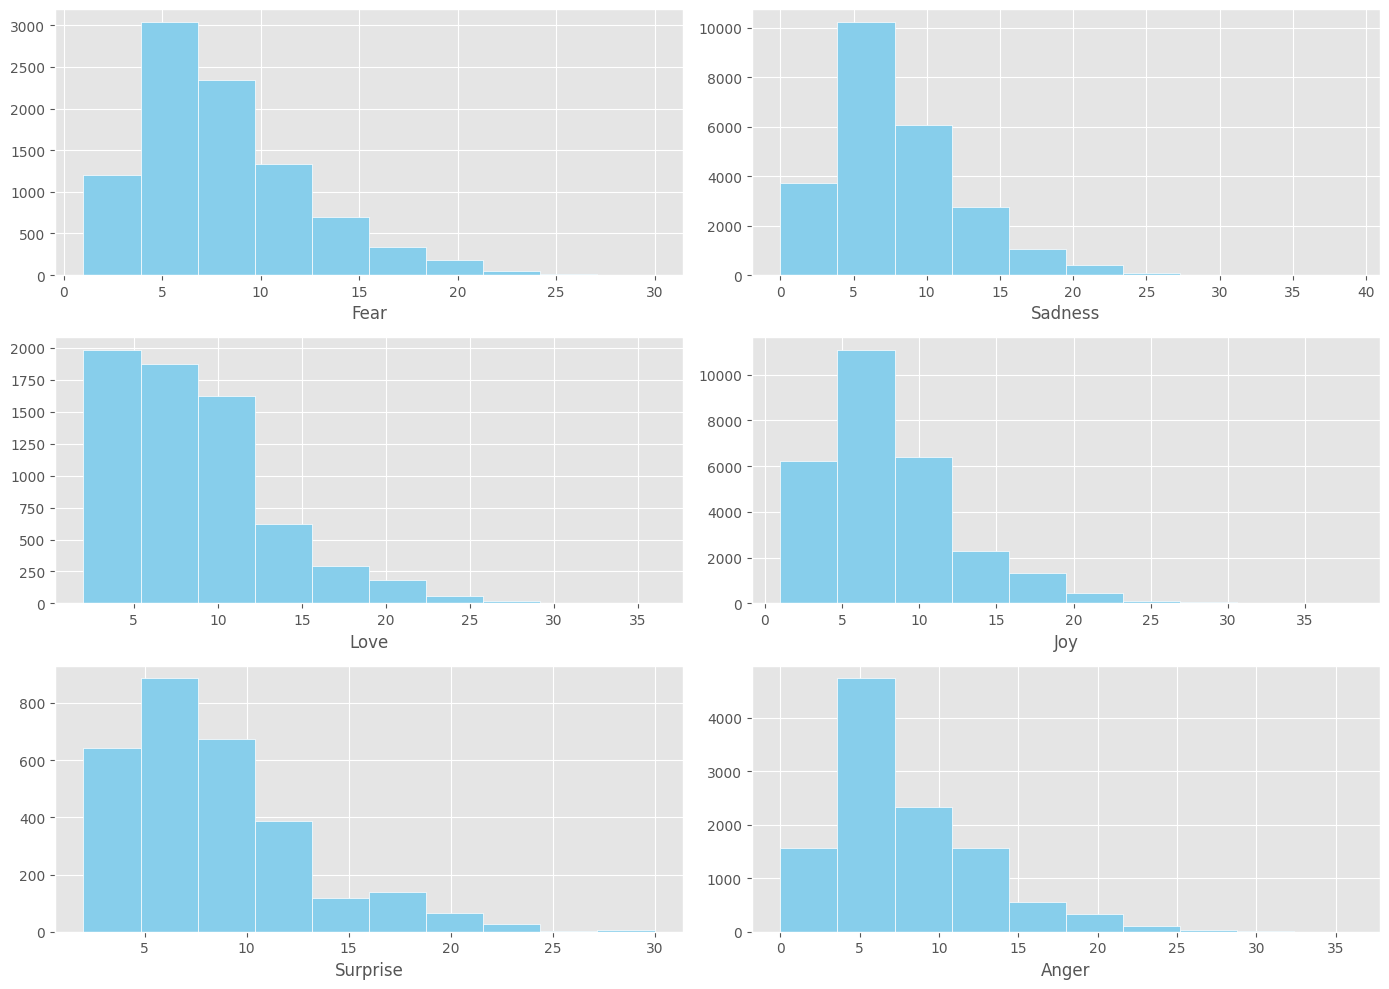

In [32]:
plt.figure(figsize=(14,10))
for i in range(len(categories)):
    plt.subplot(3,2,i+1)
    plt.hist(df[df["Category"]==categories[i]]["words_len"],color="skyblue",edgecolor="white")
    plt.xlabel(categories[i])
plt.tight_layout()
plt.show()

* As we can see from the histogram, the frequency of words length in sentence is varying with different types of emotion 

In [33]:
from collections import Counter 

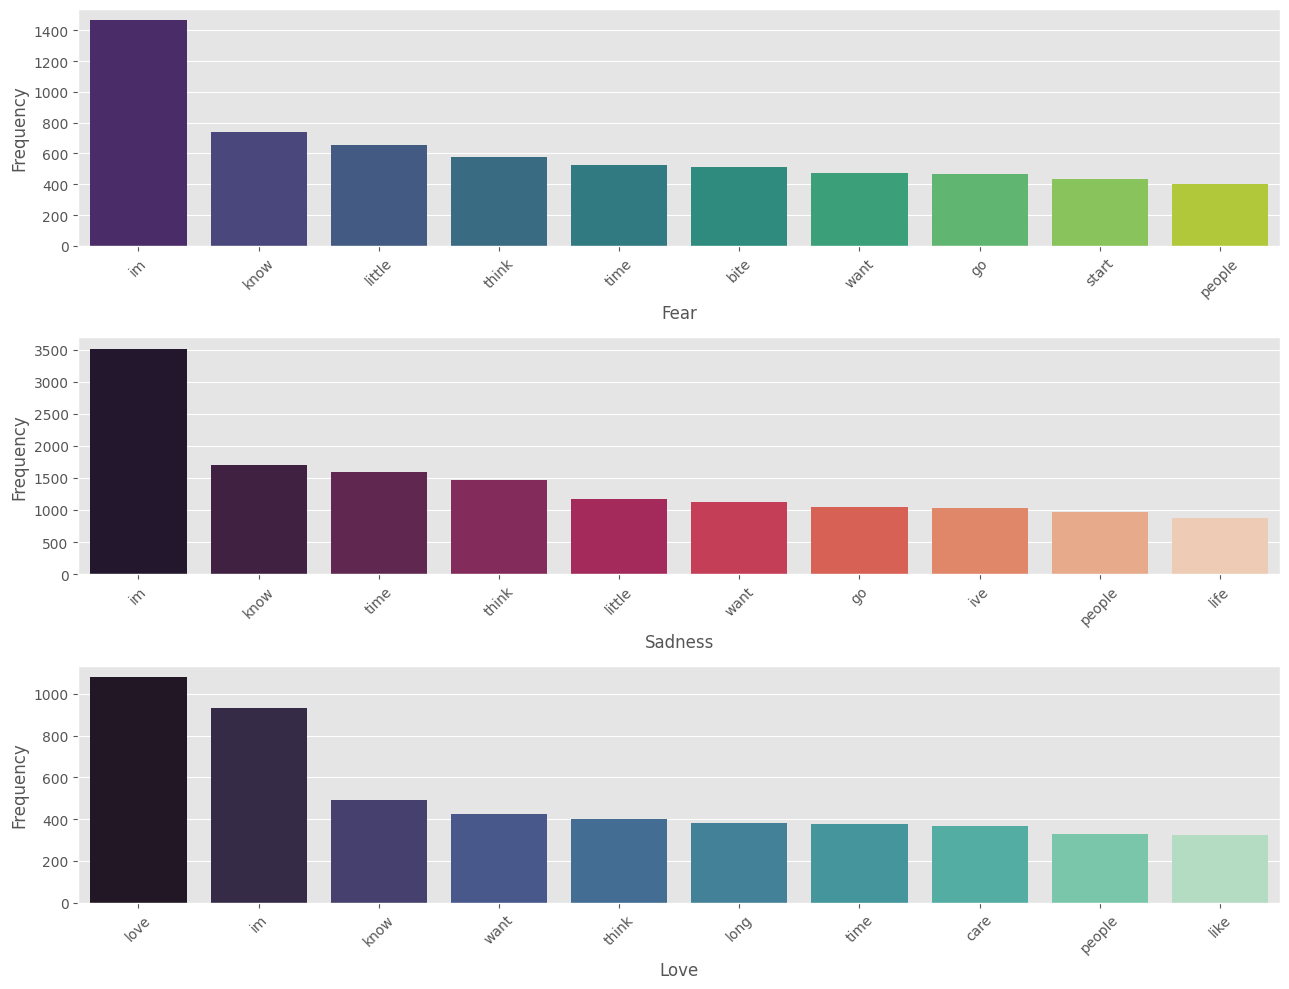

In [34]:
plt.figure(figsize=(13,10))
palettes = ["viridis","rocket","mako"]
for i in range(len(categories)//2):
    plt.subplot(3,1,i+1)
    category_dict = Counter(" ".join(df[df["Category"]==categories[i]]["c_text"]).split(" ") )
    category_dict = dict(sorted(category_dict.items(),key=lambda x:x[1],reverse=True))
    sns.barplot(x = list(category_dict.keys())[1:11],y=list(category_dict.values())[1:11],palette=palettes[i])
    plt.xlabel(categories[i])
    plt.ylabel("Frequency")
    plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

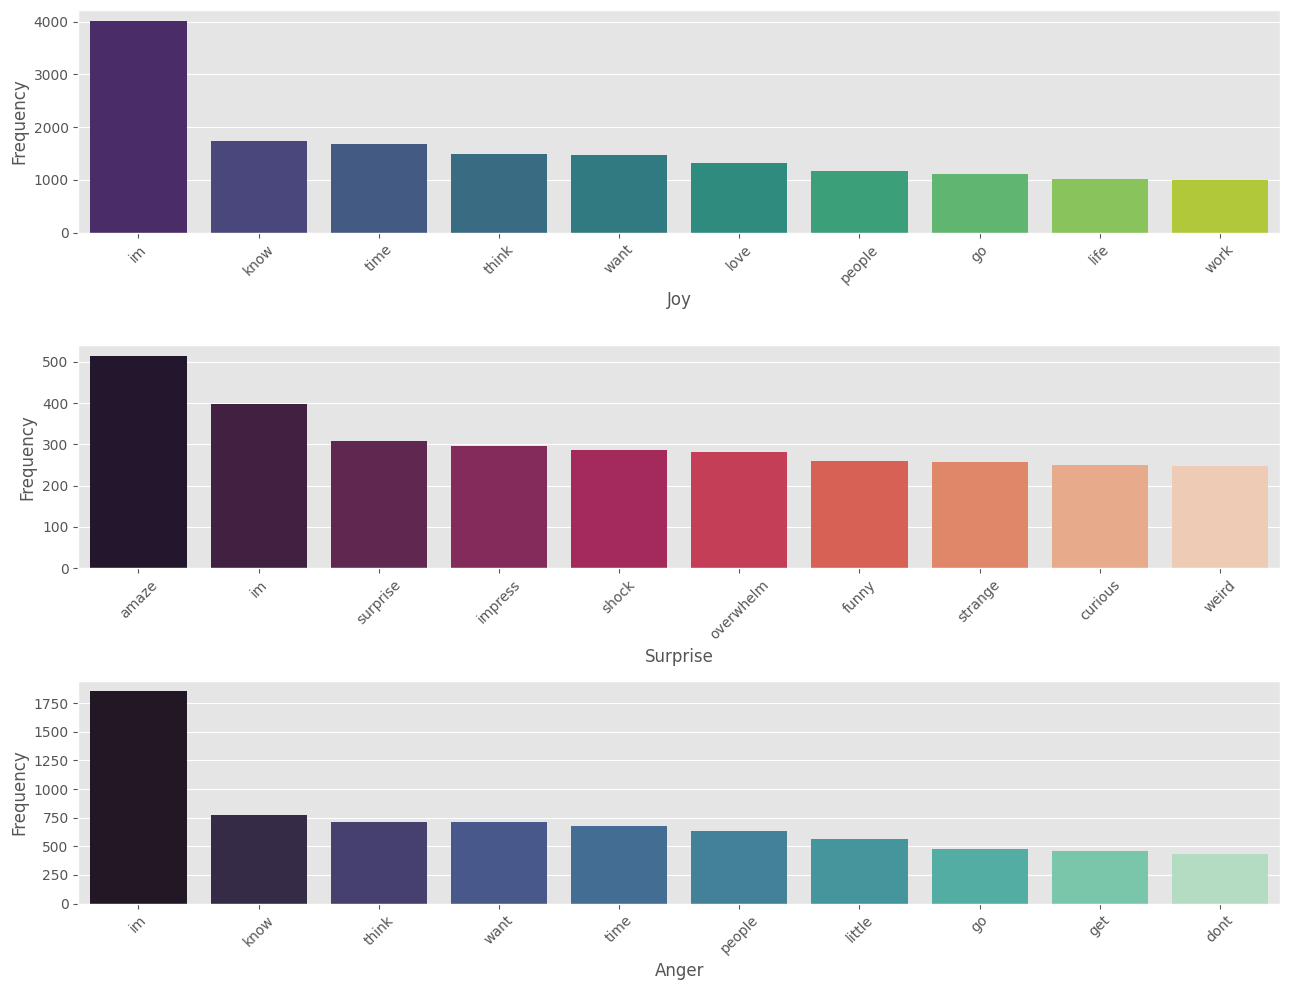

In [35]:
plt.figure(figsize=(13,10))
palettes = ["viridis","rocket","mako"]
for i in range(len(categories)//2,len(categories)):
    plt.subplot(3,1,i-2)
    category_dict = Counter(" ".join(df[df["Category"]==categories[i]]["c_text"]).split(" ") )
    category_dict = dict(sorted(category_dict.items(),key=lambda x:x[1],reverse=True))
    sns.barplot(x = list(category_dict.keys())[1:11],y=list(category_dict.values())[1:11],palette=palettes[i-3])
    plt.xlabel(categories[i])
    plt.ylabel("Frequency")
    plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

* Word cloud 

In [36]:
from wordcloud import WordCloud

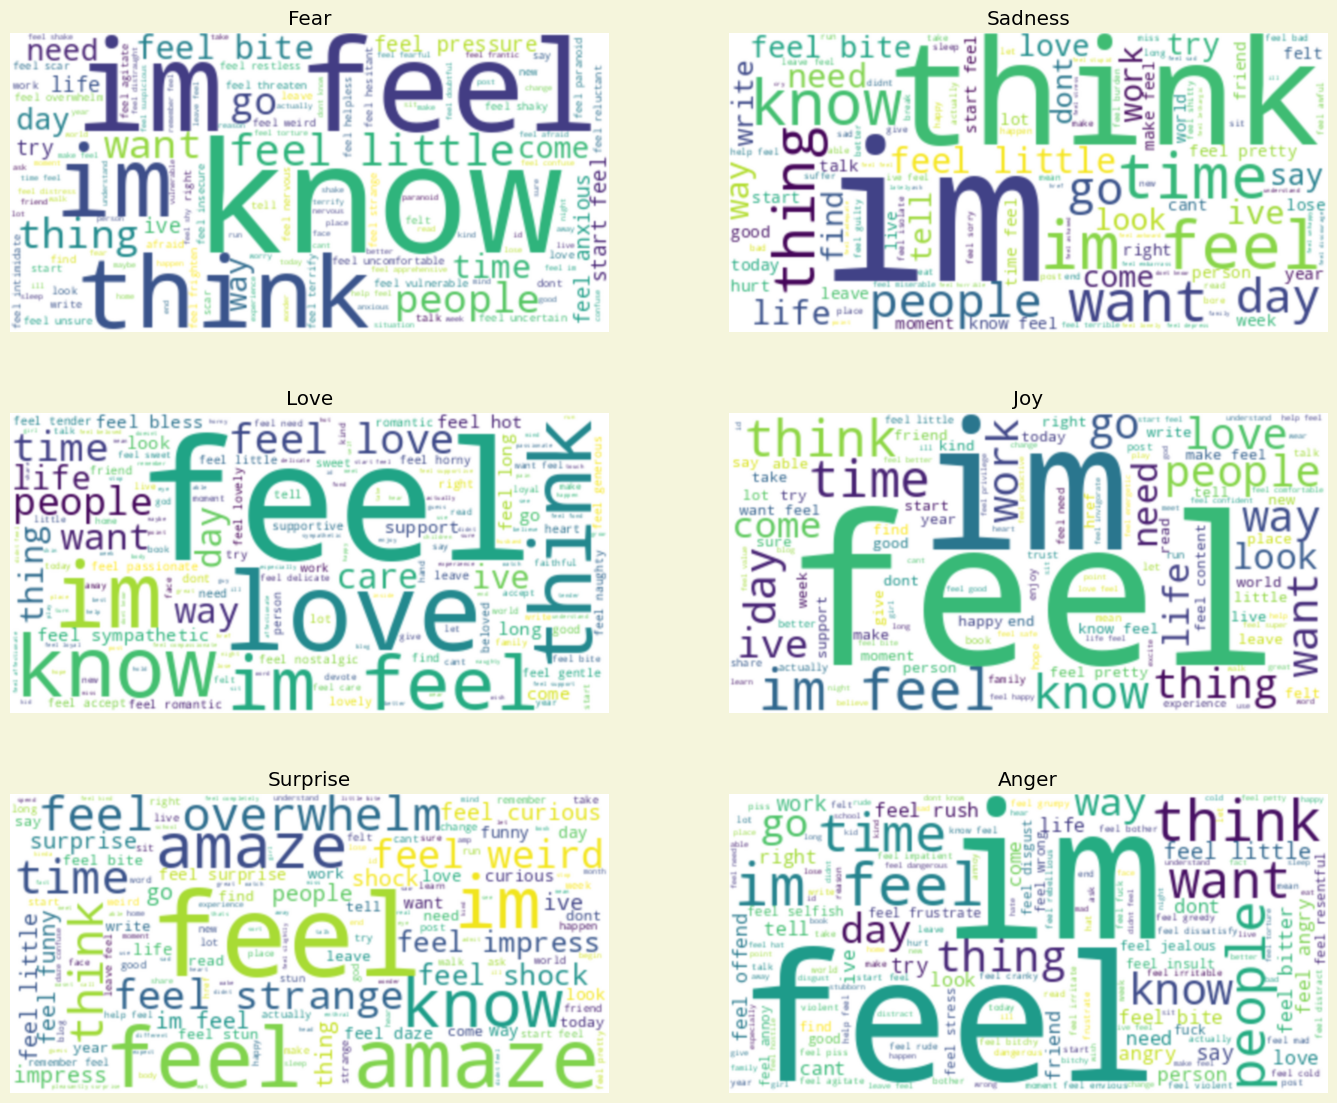

In [37]:
plt.figure(figsize=(17,14),facecolor="beige")
for i in range(len(categories)):
    plt.subplot(3,2,i+1)
    wordcloud = WordCloud(background_color="white",colormap="viridis").generate(" ".join(df[df["Category"]==categories[i]]["c_text"]))
    plt.imshow(wordcloud,interpolation = "bicubic")
    plt.title(categories[i])
    plt.axis("off")
plt.show()

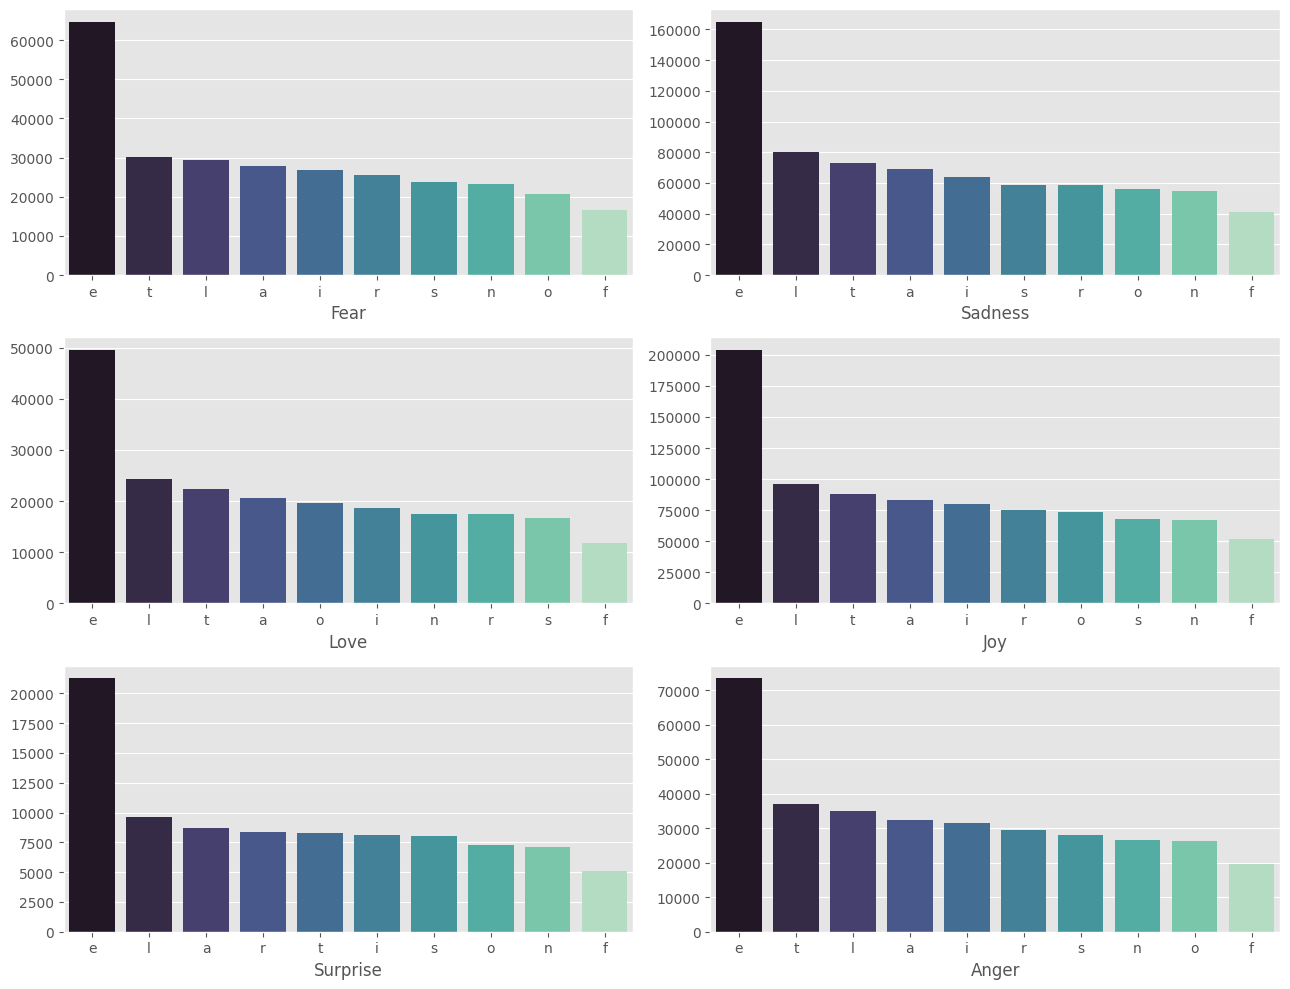

In [38]:
plt.figure(figsize=(13,10))
for index,category in enumerate(categories):
    words = " ".join(df[df["Category"]==category]["c_text"]).split(" ")
    letter_dict = {}
    for word in words:
        for letter in word:
            if letter not in letter_dict:
                letter_dict[letter] = 1
            else:
                letter_dict[letter] +=1
    d = dict(sorted(letter_dict.items(),key=lambda x:x[1],reverse=True))
    plt.subplot(3,2,index + 1)
    sns.barplot(x = list(d.keys())[:10],y=list(d.values())[:10],palette="mako")
    plt.xlabel(category)

plt.tight_layout()
plt.show()

### 4. Train Test Split 

In [39]:
X = df["c_text"]
y = df["label"]

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42,stratify=y)

In [41]:
print(f"X_train_Shape:{X_train.shape}")
print(f"X_test_Shape:{X_test.shape}")

X_train_Shape:(65947,)
X_test_Shape:(16487,)


In [42]:
print(f"y_train_value_counts: {y_train.value_counts().to_frame()}")
print(f"y_test_value_counts: {y_test.value_counts().to_frame()}")

y_train_value_counts:        count
label       
1      22384
0      19516
3       8993
4       7369
2       5326
5       2359
y_test_value_counts:        count
label       
1       5596
0       4879
3       2249
4       1842
2       1331
5        590


### 5. TF-IDF 

In [43]:
tf_idf = TfidfVectorizer(max_features=8000)

In [44]:
X_train = pd.DataFrame(tf_idf.fit_transform(X_train).toarray())
X_test  = pd.DataFrame(tf_idf.transform(X_test).toarray())

In [45]:
X_train.columns = tf_idf.get_feature_names_out()

In [46]:
X_test.columns = tf_idf.get_feature_names_out()

In [47]:
X_train.head()

,aaron,ab,abandon,abandonment,abby,abc,abdomen,abe,abide,abilities,...,zambia,zap,zen,zero,zip,zombie,zone,zoo,zoom,zumba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 6. Modelling 

* Naive Bayes  

In [48]:
naive_model = MultinomialNB()
naive_model.fit(X_train,y_train)

MultinomialNB()

In [49]:
y_test_pred = naive_model.predict(X_test)
print(f"Accuracy Score:{accuracy_score(y_test,y_test_pred)}")

Accuracy Score:0.7967489537211137


In [50]:
labels_s = list(df.sort_values(by="label")["Category"].unique())

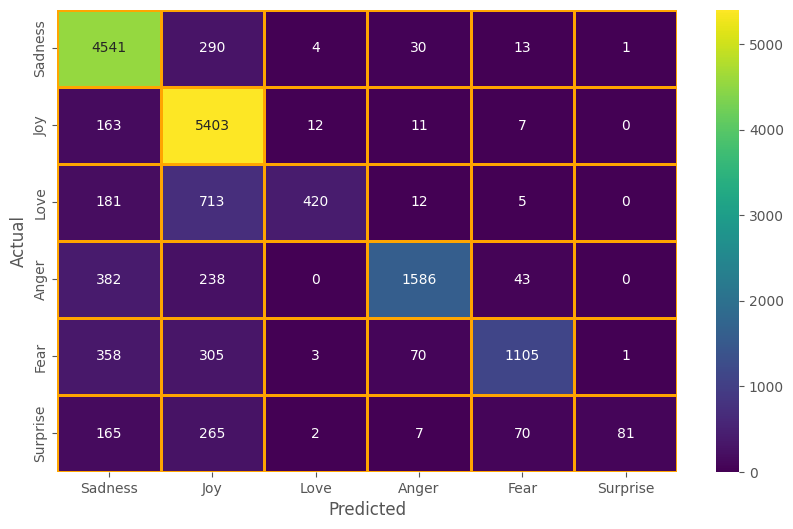

In [51]:
plt.figure(figsize=(10,6))
cf = confusion_matrix(y_test,y_test_pred)
sns.heatmap(cf,annot=True,cmap="viridis",linecolor="orange",linewidth=1,fmt = "d",
           xticklabels = labels_s,yticklabels = labels_s)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [52]:
labels_num = [str(i) for i in range(len(labels))]

In [53]:
naive_report_dict = classification_report(y_test,y_test_pred,output_dict=True)
naive_report_df = pd.DataFrame(naive_report_dict)
naive_report_df.rename(columns = {str(i):label for i,label in zip(labels_num,labels_s)},inplace=True)
naive_report_df

,Sadness,Joy,Love,Anger,Fear,Surprise,accuracy,macro avg,weighted avg
precision,0.784283,0.748960,0.952381,0.924242,0.888978,0.975904,0.796749,0.879125,0.823511
recall,0.930724,0.965511,0.315552,0.705202,0.599891,0.137288,0.796749,0.609028,0.796749
f1-score,0.851251,0.843560,0.474041,0.800000,0.716370,0.240713,0.796749,0.654322,0.774279
support,4879.000000,5596.000000,1331.000000,2249.000000,1842.000000,590.000000,0.796749,16487.000000,16487.000000


* Logistic Regression 

In [54]:
class_labels = list(y_train.value_counts().index)
class_weight = compute_class_weight(class_weight ="balanced",classes = class_labels,y = y_train)
class_weight_dict = {i:w for i,w in zip(class_labels,class_weight)}
class_weight_dict

{1: 0.4910278174886824,
 0: 0.5631874701099953,
 3: 1.2221913340005188,
 4: 1.4915411408151265,
 2: 2.0636813118037303,
 5: 4.659248269040554}

In [55]:
lg = LogisticRegression(solver = "saga",
                       class_weight = class_weight_dict)
lg.fit(X_train,y_train)

LogisticRegression(class_weight={0: 0.5631874701099953, 1: 0.4910278174886824,
                                 2: 2.0636813118037303, 3: 1.2221913340005188,
                                 4: 1.4915411408151265, 5: 4.659248269040554},
                   solver='saga')

In [56]:
y_test_pred_lg = lg.predict(X_test)
print(f"Accuracy Score:{accuracy_score(y_test,y_test_pred_lg)}")

Accuracy Score:0.8797234184509007


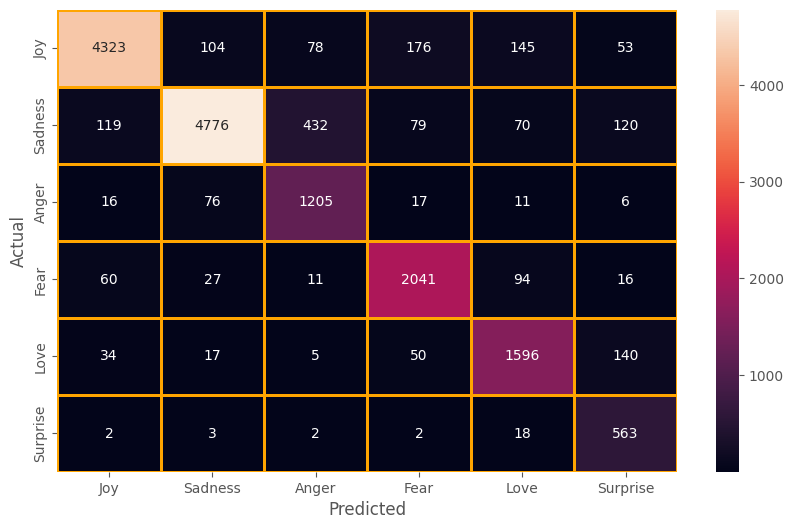

In [57]:
plt.figure(figsize=(10,6))
cf = confusion_matrix(y_test,y_test_pred_lg)
sns.heatmap(cf,annot=True,cmap="rocket",linecolor="orange",linewidth=1,fmt = "d",
           xticklabels = labels,yticklabels = labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [58]:
lg_report_dict = classification_report(y_test,y_test_pred_lg,output_dict=True)
lg_report_df = pd.DataFrame(lg_report_dict)
lg_report_df.rename(columns = {i:label for i,label in zip(labels_num,labels_s)},inplace=True)
lg_report_df

,Sadness,Joy,Love,Anger,Fear,Surprise,accuracy,macro avg,weighted avg
precision,0.949275,0.954627,0.695326,0.863002,0.825233,0.626949,0.879723,0.819069,0.893429
recall,0.886042,0.853467,0.905334,0.907514,0.866450,0.954237,0.879723,0.895507,0.879723
f1-score,0.916569,0.901217,0.786554,0.884699,0.845339,0.756720,0.879723,0.848516,0.882836
support,4879.000000,5596.000000,1331.000000,2249.000000,1842.000000,590.000000,0.879723,16487.000000,16487.000000
